# 15 PDEs: Crank-Nicholson Method 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [55]:
import numpy as np

def CrankNicholson_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)

    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = np.linalg.solve(M_eta, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

In [48]:
T_plot, (Dx, Dt, step) = CrankNicholson_T(t_max=3000, Dx=0.02, Dt=2)

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


### Visualize 

In [27]:
def plot_T(T_plot, Dx, Dt, step):
    X, Y = np.meshgrid(range(T_plot.shape[0]), range(T_plot.shape[1]))
    Z = T_plot[X, Y]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X*Dt*step, Y*Dx, Z)
    ax.set_xlabel(r"time $t$ (s)")
    ax.set_ylabel(r"position $x$ (m)")
    ax.set_zlabel(r"temperature $T$ (K)")
    fig.tight_layout()
    return ax

<IPython.core.display.Javascript object>


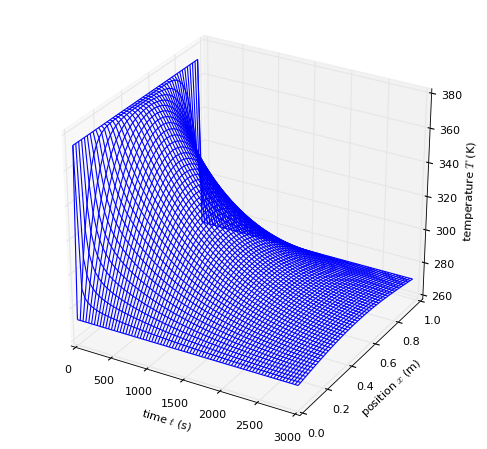

In [44]:
plot_T(T_plot, Dx, Dt, step)

## Faster solutions 

### Using matrix inverse
We only need to calculate the matrix inverse of `M_eta` once and can then use

$$
\mathbf{x}_T = \mathsf{M}(\eta)^{-1} \mathbf{b}_T
$$

In [67]:
import numpy as np

def CrankNicholson_inverse_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    
    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)
    
    inv_M_eta = np.linalg.inv(M_eta)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = np.dot(inv_M_eta, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


<IPython.core.display.Javascript object>


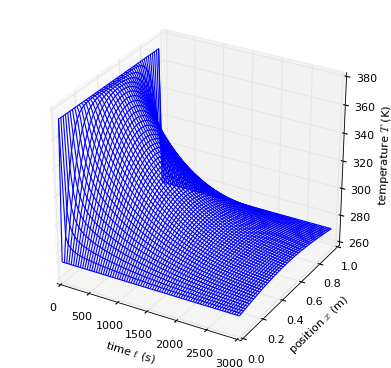

In [68]:
T_plot, (Dx, Dt, step) = CrankNicholson_inverse_T(t_max=3000, Dx=0.02, Dt=2)
plot_T(T_plot, Dx, Dt, step)

### Using special routines to solve banded or tridiagonal matrices
#### Tridiagonal matrix algorithm
The usual way to solve the matrix problem is to use a special algorithm for tridiagonal matrices, the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm). This can be done in $\mathcal{O}(N)$ and thus is *as fast as the simple iterative scheme*! 

Implementation of the Thomas algorithm in Python is not difficult (see, for instance, cdhagman's answer [Stackoverflow: Optimize A*x = B solution for a tridiagonal coefficient matrix](http://stackoverflow.com/a/23133208)).

**NOT WORKING YET**

In [115]:
def solve_tridiag_Thomas(ud, diag, ld, bb):
    # wikipedia notation = our notation: math range, np range
    #ud = c: 1 .. n-1:  0:n   c_n = c[-1] = 0
    # d = b: 1 .. n:    0:n
    #ld = a: 2 .. n:    0:n   c_1 = c[0] = 0
    #bb = d: 1 .. n:    0:n
    c = ud.copy()
    b = diag
    a = ld
    d = bb.copy()
    x = np.zeros_like(d)  # perhaps can make x superfluous
    N = len(b)
    c[0] /= b[0]
    d[0] /= b[0]
    for i in range(1, N):
        c[i] /= b[i] - a[i]*c[i-1]
        d[i] *= (d[i] - a[i]*d[i-1]) / (b[i] - a[i]*c[i-1])
    x[-1] = d[-1]
    for i in reversed(range(0, N-1)):
        x[i] = d[i] - c[i]*x[i+1]
    return x

In [76]:
%timeit list(range(10-1, 0, -1))

1000000 loops, best of 3: 1.37 µs per loop


In [77]:
%timeit list(reversed(range(1, 10)))

1000000 loops, best of 3: 1.81 µs per loop


In [106]:
ud = -np.ones(11)
ud[0] = 0
d = 2*np.ones(11)
ld = -np.ones(11)
ld[-1] = 0

b = np.arange(11, dtype=np.float64)

M = np.diagflat(ud[1:], 1) + np.diagflat(d, 0) + np.diagflat(ld[:-1], -1)

In [114]:
x = solve_tridiag_Thomas(ud, d, ld, b)
print(np.allclose(np.dot(M, x), b))
np.dot(M, x)

False


array([ -6.39419853e+04,   1.00000000e+00,   4.50000000e+00,
         1.56666667e+01,   5.87500000e+01,   2.58600000e+02,
         1.35683333e+03,   8.38557143e+03,   5.99358750e+04,
         4.87113889e+05,  -4.93138700e+05])

In [111]:
x

array([  0.00000000e+00,   6.39419853e+04,   1.27882971e+05,
         1.91819456e+05,   2.55740275e+05,   3.19602343e+05,
         3.83205812e+05,   4.45452447e+05,   4.99313511e+05,
         4.93238700e+05,   5.00000000e+01])

In [108]:
x0 = scipy.linalg.solve_banded((1,1), np.array([ud, d, ld]), b)
print(np.allclose(np.dot(M, x0), b))

True


In [112]:
x0

array([ 18.33333333,  36.66666667,  54.        ,  69.33333333,
        81.66666667,  90.        ,  93.33333333,  90.66666667,
        81.        ,  63.33333333,  36.66666667])

In [109]:
M

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])

In [ ]:
import numpy as np
import scipy.linalg

def CrankNicholson_Thomas_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    
    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)
    
    M_eta_ab = extract_tridiag_ab(M_eta)
    ud_M = M_eta_ab[0]
    d_M = M_eta_ab[1]
    ld_M = M_eta_ab[2]
    
    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = solve_tridiag_Thomas(ud_M, d_M, ld_M, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

In [83]:
T_plot, (Dx, Dt, step) = CrankNicholson_Thomas_T(t_max=3000, Dx=0.02, Dt=2)
plot_T(T_plot, Dx, Dt, step)

Nx = 49, Nt = 1500
eta = 0.4876543209876543


ZeroDivisionError: division by zero

> <ipython-input-81-80b89612ef7a>(42)CrankNicholson_Thomas_T()
     40     ld_M = M_eta_ab[2]
     41 
---> 42     1/0
     43 
     44     t_index = 0

ipdb> p M_eta_ab
array([[ 0.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [ 6.10126582,  6.10126582,  6.10126582,  6.10126582,  6.10126582,
         6.10126582,  6.10126582,  6.10126582,  6.10126582,  6.10

In [84]:
%pdb

Automatic pdb calling has been turned OFF


#### Special routines for *banded* matrices
Tridiagonal matrices are a special (simple) case of *banded matrices*. **scipy** contains special, fast routines to solve matrix equations for banded matrices, namely [scipy.linalg.solve_banded()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html#scipy.linalg.solve_banded). The only difficulty is to format the input in a form suitable for the function:

In [53]:
import scipy.linalg

def solve_tridiagonal_banded(A, b):
    ab = extract_tridiag_ab(A)
    return scipy.linalg.solve_banded((1, 1), ab, b)

def extract_tridiag_ab(A):
    # extract diagonals and pad (as required for solve_banded())
    ud = np.insert(np.diag(A, 1), 0, 0)         # upper diagonal
    d = np.diag(A)                              # main diagonal
    ld = np.insert(np.diag(A, -1), len(d)-1, 0) # lower diagonal
    # matrix as required by solve_banded()
    ab = np.array([ud, d, ld])
    return ab
                       

Faster Crank-Nicholson:

In [58]:
import numpy as np
import scipy.linalg

def CrankNicholson_banded_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    
    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)
    
    M_eta_ab = extract_tridiag_ab(M_eta)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = scipy.linalg.solve_banded((1, 1), M_eta_ab, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


<IPython.core.display.Javascript object>


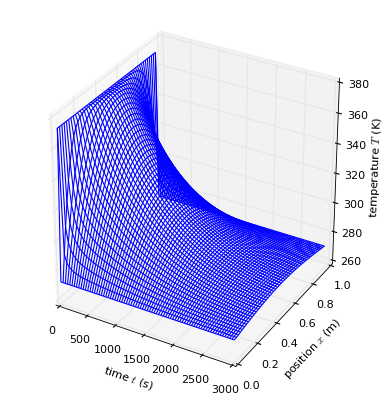

In [64]:
T_plot, (Dx, Dt, step) = CrankNicholson_banded_T(t_max=3000, Dx=0.02, Dt=2)
plot_T(T_plot, Dx, Dt, step)

## Benchmarking
For the original problem, `np.linalg.solve` is at least as fast as the banded solution, but for 10 times smaller step size (from 0.02 to 0.002) ie from 100 x 100 to 1000 x 1000 matrix, the slow-down is 32/0.25 ~ 120. 

In [62]:
%timeit CrankNicholson_banded_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

1 loop, best of 3: 250 ms per loop


In [63]:
%timeit CrankNicholson_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

1 loop, best of 3: 32.3 s per loop


In [70]:
%timeit CrankNicholson_inverse_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

1 loop, best of 3: 422 ms per loop


# Numpy shenanigans 

In [4]:
np.insert(np.diag(A,1), 0, 0)

array([ 0, -5, -5, -5])

In [5]:
np.diag(A)

array([20, 15, 15, 10])

In [7]:
np.insert(np.diag(A,-1), len(np.diag(A))-1, 0)

array([-5, -5, -5,  0])

In [18]:
Nx = 10
np.diagflat(-np.ones(Nx-1), 1) + np.diagflat(2*np.ones(Nx), 0) + np.diagflat(-np.ones(Nx-1), -1)

array([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])